In [182]:
import numpy as np
import matplotlib.pyplot as plt
import preprocessing as pp
import implementations as imp
import helpers as hlp
import os
from functions import *
import csv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and clean data

In [183]:
cwd = os.getcwd()
path = cwd + "/dataset_to_release"
x_train_, x_test_, y_train_, train_ids_, test_ids_ = hlp.load_csv_data(path)

In [184]:
x = x_train_.copy()
x_submit = x_test_.copy()
y = y_train_.copy()

In [185]:
X_train, X_test, Y = pp.clean_data_final(x_train_, y_train_, x_test_)

Unknown values replaced with NaN, according to the documentation
Max median NaN score rows :  0.6060963867246555
Max median NaN score columns :  0.7652518774030354
Number of rows dropped because of a NaN score > 0.5:  37081
Number of columns dropped because of a NaN score > 0.5:  150
Number of columns with std < 0.1: 5
Number of columns with correl_coef > 0.95: 11
Handling NaN values...
Data clipped between 5th and 95th percentiles
Number of columns with std < 0.1 after cleaning: 11
Number of columns with corr_coef> 0.95 after cleaning: 14
The data has been cleaned and standardized
The cleaned x_train data has the following shape:  (291054, 130)
The cleaned y_train has the following shape:  (291054,)
The cleaned x_test has the following shape:  (109379, 130)


In [186]:
x_train, y_train, x_test, y_test = pp.split_data(
    X_train, Y, 0.8
)  # 80% training, 20% testing

In [187]:
y = Y.copy()
y = np.where(y == -1, 0, 1)  # change -1 to 0
y = y.astype(int)  # change to int

y_train_ = y_train.copy()
y_train_ = np.where(y_train == -1, 0, 1)  # change -1 to 0
y_train_ = y_train.astype(int)  # change to int

# Gradient Descent

### Cross validation for Grid Search Hyperparameter tuning


In [188]:
max_iters = 100
w_initial = np.zeros(x_train.shape[1])
param_grid = {"max_iters": [100], "gamma": np.linspace(0.001, 0.25, 10)}

In [194]:
best_w, best_params, losses = grid_search_gd(y_train, x_train, param_grid, w_initial)

Max Iters: 100, Gamma: 0.001, Avg Loss: 0.4833628234261095
Max Iters: 100, Gamma: 0.028666666666666667, Avg Loss: 0.46539218910808255
Max Iters: 100, Gamma: 0.05633333333333333, Avg Loss: 0.464044835539028
Max Iters: 100, Gamma: 0.08399999999999999, Avg Loss: 0.4632665779704859
Max Iters: 100, Gamma: 0.11166666666666666, Avg Loss: 0.4626586955198668
Max Iters: 100, Gamma: 0.13933333333333334, Avg Loss: 0.46215339469986977
Max Iters: 100, Gamma: 0.16699999999999998, Avg Loss: 0.46172220235010075
Max Iters: 100, Gamma: 0.19466666666666665, Avg Loss: 0.46318230847464703
Max Iters: 100, Gamma: 0.22233333333333333, Avg Loss: 1.208691662867412e+19
Max Iters: 100, Gamma: 0.25, Avg Loss: 3.2129472477012974e+36


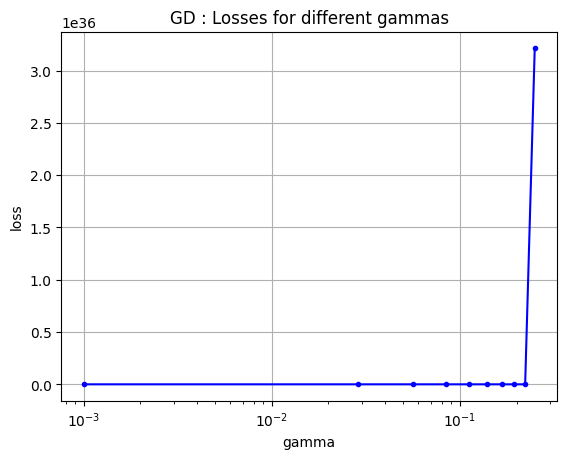

In [195]:
# plot losses for different gammas
import matplotlib.pyplot as plt

gd_gammas = [x[0] for x in losses]
gd_losses = [x[1] for x in losses]
plt.figure()
plt.semilogx(gd_gammas, gd_losses, marker=".", color="b", label="loss")
plt.xlabel("gamma")
plt.ylabel("loss")
plt.title("GD : Losses for different gammas")
# plt.legend(loc=2)
plt.grid(True)
plt.show()

In [196]:
print("Best gamma: ", best_params["gamma"])

Best gamma:  0.16699999999999998


### Training with optimal hyperparameters

In [197]:
best_gd_ws, best_gd_losses = imp.gradient_descent(
    y_train, x_train, np.zeros(x_train.shape[1]), max_iters, best_params["gamma"]
)

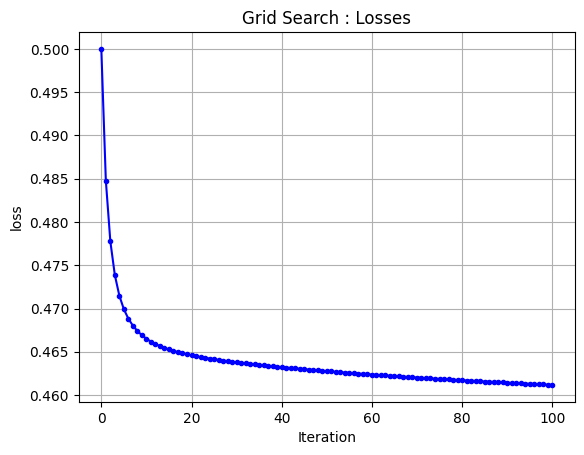

In [198]:
# plot gradient descent losses
plt.figure()
plt.plot(best_gd_losses, marker=".", color="b", label="Loss")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.title("Grid Search : Losses")
# plt.legend(loc=2)
plt.grid(True)
plt.show()

In [199]:
best_gd_w = best_gd_ws[-1]

### Determining optimal threshold

In [200]:
gamma = gd_gammas[np.argmin(gd_losses)]
y_train_pred = x_train @ best_gd_w
optimal_threshold = best_threshold(y_train_pred, y_train)
print(optimal_threshold)

0.2


### Evaluating performance on test set

In [201]:
y_test_pred = x_test @ best_gd_w
y_test_pred = np.where(y_test_pred > optimal_threshold, 1, -1)
print(f1_score_(y_test_pred, y_test))
print(accuracy_score_(y_test_pred, y_test))

0.33884672763832135
0.8248956382814244


# Stochastic Gradient Descent

### Hyperparameter tuning

In [202]:
param_grid_sgd = {
    "max_iters": [100],
    "gamma": np.linspace(0.0001, 0.2, 20),
    "batch_size": [32, 64, 128, 256, 512, 1024],
}

In [205]:
best_w_sgd, best_params_sgd, losses_sgd = grid_search_sgd(
    y_train, x_train, param_grid_sgd, np.zeros(x_train.shape[1])
)

Max Iters: 100, Gamma: 0.0001, Avg Loss: 0.4968932449013743
Max Iters: 100, Gamma: 0.0001, Avg Loss: 0.4969518018186777
Max Iters: 100, Gamma: 0.0001, Avg Loss: 0.4968540430534315
Max Iters: 100, Gamma: 0.0001, Avg Loss: 0.49690143341662607
Max Iters: 100, Gamma: 0.0001, Avg Loss: 0.49691668374423587
Max Iters: 100, Gamma: 0.0001, Avg Loss: 0.4969065117927344
Max Iters: 100, Gamma: 0.010621052631578948, Avg Loss: 0.47792978690832266
Max Iters: 100, Gamma: 0.010621052631578948, Avg Loss: 0.4734636425253217
Max Iters: 100, Gamma: 0.010621052631578948, Avg Loss: 0.47151377260771377
Max Iters: 100, Gamma: 0.010621052631578948, Avg Loss: 0.4700650213155694
Max Iters: 100, Gamma: 0.010621052631578948, Avg Loss: 0.4694088989758427
Max Iters: 100, Gamma: 0.010621052631578948, Avg Loss: 0.4690858555573693
Max Iters: 100, Gamma: 0.021142105263157896, Avg Loss: 0.4887691316494169
Max Iters: 100, Gamma: 0.021142105263157896, Avg Loss: 0.47572425403360724
Max Iters: 100, Gamma: 0.021142105263157896

In [206]:
best_params_sgd

{'max_iters': 100, 'gamma': 0.0632263157894737, 'batch_size': 1024}

### Training

In [207]:
sgd_ws, sgd_losses = imp.stochastic_gradient_descent(
    y_train,
    x_train,
    np.zeros(x_train.shape[1]),
    best_params_sgd["max_iters"],
    best_params_sgd["gamma"],
    best_params_sgd["batch_size"],
)
best_sgd_w = sgd_ws[-1]

In [208]:
# optimal threshold
y_train_pred = x_train @ best_sgd_w
optimal_threshold = best_threshold(y_train_pred, y_train)
print(optimal_threshold)

0.17


### Evaluating Performance on Test Set

In [209]:
y_test_pred = x_test @ best_sgd_w
y_test_pred = np.where(y_test_pred > optimal_threshold, 1, -1)
print(f1_score_(y_test_pred, y_test))
print(accuracy_score_(y_test_pred, y_test))

0.336454280155642
0.8125096631220903


# Least squares

### Testing (no tuning necessary)

In [210]:
w_least, loss_least = imp.least_squares(y_train, x_train)
loss = imp.compute_loss(y_test, x_test, w_least)
print("Loss:", loss)

y_pred_train = x_train @ w_least
optimal_threshold = best_threshold(y_pred_train, y_train)
print(optimal_threshold)
y_pred_test = x_test @ w_least
y_pred_test = np.where(y_pred_test > optimal_threshold, 1, -1)
print(f1_score_(y_pred_test, y_test))
print(accuracy_score_(y_pred_test, y_test))

Loss: 0.45347733322532097
0.17
0.33024616134535706
0.8111697101922317


## Ridge Regression

In [215]:
param_grid_ridge = {"lambdas": np.logspace(-10, 0, 10)}

best_w_ridge, best_lambda, losses_ridge = grid_search_ridge(
    y_train, x_train, param_grid_ridge, np.zeros(x_train.shape[1])
)

Lambda: 1e-10, Avg Loss: 0.455952029018896
Lambda: 1.2915496650148826e-09, Avg Loss: 0.45595202899656984
Lambda: 1.6681005372000592e-08, Avg Loss: 0.4559520287094411
Lambda: 2.1544346900318867e-07, Avg Loss: 0.45595202520518663
Lambda: 2.782559402207126e-06, Avg Loss: 0.45595201376593053
Lambda: 3.5938136638046256e-05, Avg Loss: 0.455957033500024
Lambda: 0.0004641588833612782, Avg Loss: 0.4563611975355622
Lambda: 0.005994842503189421, Avg Loss: 0.45902976890464675
Lambda: 0.07742636826811278, Avg Loss: 0.4644746130629705
Lambda: 1.0, Avg Loss: 0.4748862289061586


In [216]:
best_lambda

{'lambdas': 2.782559402207126e-06}

### Training

In [217]:
w, l = imp.ridge_regression(y_train, x_train, best_lambda["lambdas"])
y_pred_train = x_train @ w
optimal_threshold = best_threshold(y_pred_train, y_train)
print(optimal_threshold)

0.17


## Testing

In [218]:
y_pred_test = x_test @ w
y_pred_test = np.where(y_pred_test > optimal_threshold, 1, -1)
print(f1_score_(y_pred_test, y_test))
print(accuracy_score_(y_pred_test, y_test))

0.3302059217740953
0.8111353524247994
